# **Welcome To the Notebook** 


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark

Importing Modules

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
!pip install matplotlib
!pip install plotly
!pip install seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# pandas module 
import pandas as pd

# pyspark SQL functions 
from pyspark.sql.functions import col, when, count, udf, isnan

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

25/02/21 18:20:36 WARN Utils: Your hostname, Syukris-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.187 instead (on interface en0)
25/02/21 18:20:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/21 18:20:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loading our data

In [4]:
data = spark.read.csv("dataset.csv", header=True, inferSchema=True)

# Show first 5 rows of the dataset
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [5]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension 

In [6]:
# Get number of rows
num_rows = data.count()

# Get number of columns
num_cols = len(data.columns)

print(f"Dataset dimensions: ({num_rows}, {num_cols})")

Dataset dimensions: (7043, 21)


### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis 
- Univariate Analysis 
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [7]:
# Initialize lists
string_cols = []
numeric_cols = []
date_cols = []

# Categorize columns
for col_name, col_type in data.dtypes:
    if col_type.startswith("string"):
        string_cols.append(col_name)
    elif col_type in ("int", "bigint", "double", "float", "decimal"):
        numeric_cols.append(col_name)
    elif col_type in ("date", "timestamp"):
        date_cols.append(col_name)

# Print categorized column names
print("String Columns:", string_cols)
print("Numeric Columns:", numeric_cols)
print("Date Columns:", date_cols)

String Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
Numeric Columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Date Columns: []


Let's get all the numerical features and store them into a pandas dataframe.

In [8]:
# Select numerical features
df_numeric = data.select(numeric_cols)

# Covert to Pandas DataFrame
df_numeric_pandas = df_numeric.toPandas()

# Display the results
print(df_numeric_pandas.head())


   tenure  MonthlyCharges  TotalCharges
0       1           29.85         29.85
1      34           56.95       1889.50
2       2           53.85        108.15
3      45           42.30       1840.75
4       2           70.70        151.65


Let's create histograms to analyse the distribution of our numerical columns. 

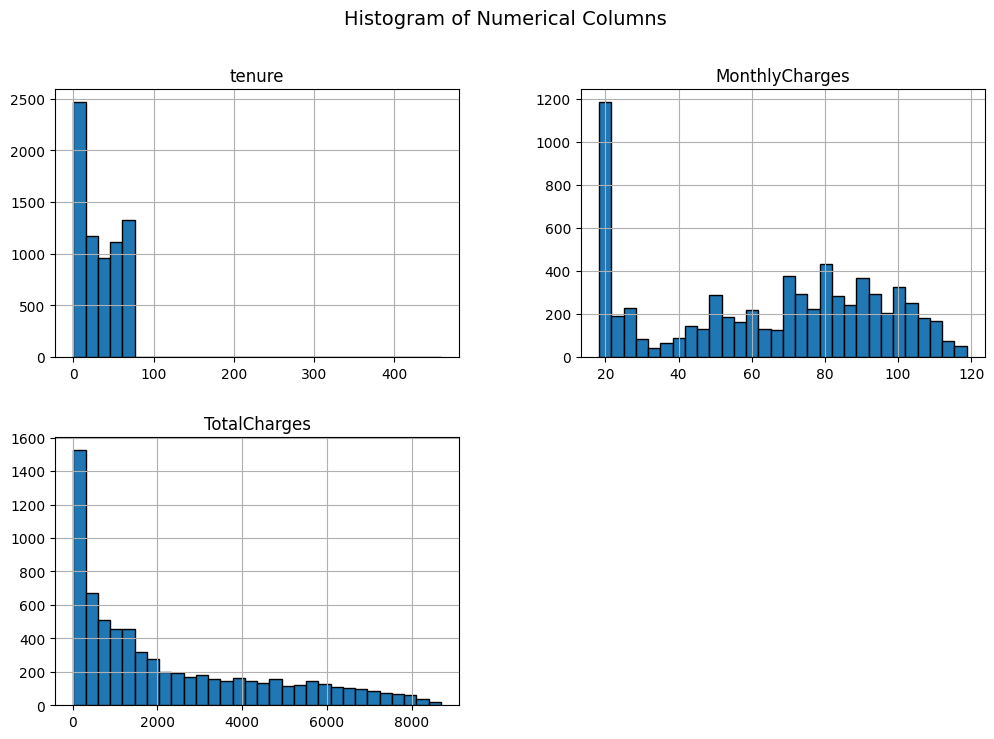

In [9]:
# Create a histogram
df_numeric_pandas.hist(figsize=(12,8),
                       bins=30,
                       edgecolor="black")
plt.suptitle("Histogram of Numerical Columns", fontsize=14)
plt.show()

Let's generate the correlation matrix 

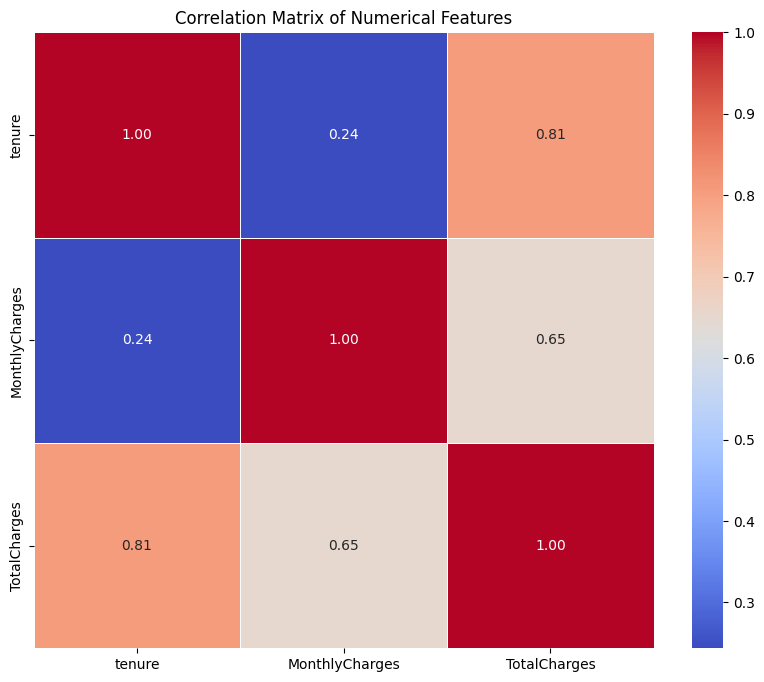

In [10]:
# Compute the correlation matrix
corr_matrix = df_numeric_pandas.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Let's check the unique value count per each categorical variables

In [11]:
# Count unique values per categorical columns
unique_counts = {col: data.select(col).distinct().count() for col in string_cols}

# Convert to Pandas DataFrame
unique_counts_df = pd.DataFrame(list(unique_counts.items()), columns=["Column", "Unique Count"])

# Display results
print(unique_counts_df)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=29773Kb max_used=29853Kb free=101298Kb
 bounds [0x00000001061f8000, 0x0000000107f58000, 0x000000010e1f8000]
 total_blobs=11578 nmethods=10634 adapters=856
 compilation: disabled (not enough contiguous free space left)
              Column  Unique Count
0         customerID          7043
1             gender             2
2      SeniorCitizen             2
3            Partner             2
4         Dependents             2
5       PhoneService             2
6      MultipleLines             3
7    InternetService             3
8     OnlineSecurity             3
9       OnlineBackup             3
10  DeviceProtection             3
11       TechSupport             3
12       StreamingTV             3
13   StreamingMovies             3
14          Contract             3
15  PaperlessBilling             2
16     PaymentMethod             4
17             Churn             2


Let's find number of null values in all of our dataframe columns

In [12]:
# Count null values for each column
null_counts = {col_name: data.filter(col(col_name).isNull()).count() for col_name in data.columns}

# Convert to Pandas DataFrame for easy viewing
null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Column", "Null_Count"])

# Display the results
print(null_counts_df)

              Column  Null_Count
0         customerID           0
1             gender           0
2      SeniorCitizen           0
3            Partner           0
4         Dependents           0
5             tenure           0
6       PhoneService           0
7      MultipleLines           0
8    InternetService           0
9     OnlineSecurity           0
10      OnlineBackup           0
11  DeviceProtection           0
12       TechSupport           0
13       StreamingTV           0
14   StreamingMovies           0
15          Contract           0
16  PaperlessBilling           0
17     PaymentMethod           0
18    MonthlyCharges           0
19      TotalCharges          11
20             Churn           0


### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [13]:
# Get columns with missing values
missing_columns = null_counts_df.loc[:, (null_counts_df != 0).any(axis=0)].columns.tolist()

# Display columns with missing values
print("Columns with missing values: ", null_counts)

Columns with missing values:  {'customerID': 0, 'gender': 0, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0, 'tenure': 0, 'PhoneService': 0, 'MultipleLines': 0, 'InternetService': 0, 'OnlineSecurity': 0, 'OnlineBackup': 0, 'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 0, 'StreamingMovies': 0, 'Contract': 0, 'PaperlessBilling': 0, 'PaymentMethod': 0, 'MonthlyCharges': 0, 'TotalCharges': 11, 'Churn': 0}


Creating our Imputer

In [14]:
# Identify numerical columns with missing values
num_missing_cols = [c for c in numeric_cols if data.filter(col(c).isNull()).count()> 0]

# Apply Imputer for numerical columns
if num_missing_cols:
    imputer = Imputer(inputCols=num_missing_cols, outputCols=[c + "_imputed" for c in num_missing_cols], strategy="mean")
    data = imputer.fit(data).transform(data)
    
# Identify string columns with missing values
str_missing_cols = [c for c in string_cols if data.filter(col(c).isNull()).count() > 0]

# Fill missing values with "Unknown"
data = data.fillna({c: "Unknown" for c in str_missing_cols})

# Drop old numerical columns and rename imputed column
for col_name in num_missing_cols:
    data = data.drop(col_name).withColumnRenamed(col_name + "_imputed", col_name)
    
# Show updated DataFrame
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|Churn|TotalCharges|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

Let's check the missing value counts again

In [15]:
# Count NULL and NaN values for each column
null_counts_df = data.select(
    [(count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)) for c in data.columns]
).toPandas()

# Transpose for better readability
null_counts_df = null_counts_df.T.reset_index()
null_counts_df.columns = ["Column", "Missing_Values"]

# Display missing value counts
print(null_counts_df)

              Column  Missing_Values
0         customerID               0
1             gender               0
2      SeniorCitizen               0
3            Partner               0
4         Dependents               0
5             tenure               0
6       PhoneService               0
7      MultipleLines               0
8    InternetService               0
9     OnlineSecurity               0
10      OnlineBackup               0
11  DeviceProtection               0
12       TechSupport               0
13       StreamingTV               0
14   StreamingMovies               0
15          Contract               0
16  PaperlessBilling               0
17     PaymentMethod               0
18    MonthlyCharges               0
19             Churn               0
20      TotalCharges               0


**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100 

In [16]:
# Filter customers with tenure > 100
data.filter(col("tenure") > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+-----+------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|Churn|TotalCharges|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+-----+------------+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [17]:
# Remove rows where tenure > 100
data = data.filter(col("tenure") <= 100)

# Verify changes
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|Churn|TotalCharges|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

### **Task 4 - Feature Preparation**
- Numerical Features 
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [18]:
# Create VectorAssembler
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="num_features")

# Transform the DataFrame
data = assembler.transform(data)

# Show results
data.select("num_features").show(truncate=False)

+---------------------+
|num_features         |
+---------------------+
|[1.0,29.85,29.85]    |
|[34.0,56.95,1889.5]  |
|[2.0,53.85,108.15]   |
|[45.0,42.3,1840.75]  |
|[2.0,70.7,151.65]    |
|[8.0,99.65,820.5]    |
|[22.0,89.1,1949.4]   |
|[10.0,29.75,301.9]   |
|[28.0,104.8,3046.05] |
|[62.0,56.15,3487.95] |
|[13.0,49.95,587.45]  |
|[16.0,18.95,326.8]   |
|[58.0,100.35,5681.1] |
|[49.0,103.7,5036.3]  |
|[25.0,105.5,2686.05] |
|[69.0,113.25,7895.15]|
|[52.0,20.65,1022.95] |
|[71.0,106.7,7382.25] |
|[10.0,55.2,528.35]   |
|[21.0,90.05,1862.9]  |
+---------------------+
only showing top 20 rows



**Numerical Scaling** <br>
Let's standardize all of our numerical features. 

In [19]:
# Apply StandardScaler
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Display results
data.select("scaled_features").show(truncate=False)

+---------------------------------------------------------------+
|scaled_features                                                |
+---------------------------------------------------------------+
|[-1.2775627682208068,-1.1601185306298927,-0.9950152145479357]  |
|[0.06615490566075274,-0.25954460633168197,-0.17398881878893097]|
|[-1.2368440508304566,-0.36256228770896815,-0.9604461468266279] |
|[0.5140607969546059,-0.7463862296146632,-0.19551170578016666]  |
|[-1.2368440508304566,0.19738865784176432,-0.9412411092036791]  |
|[-0.9925317464883547,1.1594408758651296,-0.6459470996839253]   |
|[-0.4224697030234507,0.8088484440811394,-0.14754326123457157]  |
|[-0.9110943117076542,-1.1634416816420632,-0.8749064677588962]  |
|[-0.17815739868134897,1.330583152991911,0.3366223596667339]    |
|[1.2062789925905608,-0.2861298144290463,0.5317190522088272]    |
|[-0.7889381595366033,-0.4921651771836183,-0.7488375368799761]  |
|[-0.6667820073655525,-1.522341990956479,-0.8639132393264497]   |
|[1.043404

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [ ]:
# Apply StringIndexer to each string column

Let's combine all of our categorifal features in to one feature vector.

Now let's combine categorical and numerical feature vectors.

### **Task 5 - Model Training**
- Train and Test data splitting 
- Creating our model 
- Training our model 
- Make initial predictions using our model

In this task, we are going to start training our model

Now let's create and train our desicion tree

Let's make predictions on our test data

### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set 
- Calculating area under the ROC curve for the `training` set 
- Hyper parameter tuning

Let's get the AUC for our `training` set

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model. 

In [20]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

Let's visualize our results

### **7 - Model Deployment**
- Giving Recommendations using our model 



We were asked to recommend a solution to reduce the customer churn. 


Let's create a bar chart to visualize the customer churn per contract type

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts. 